# Analysing WaPOR data

## 1. Warp raster data

### Example
For this exercise, we can make use of the user-defined functions we made in the previous exercise to read can write raster data.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from osgeo import gdal

def GetRasterInfo(in_fh):
    DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    bandnumber=1
    Subdataset = DataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    xsize = DataSet.RasterXSize
    ysize = DataSet.RasterYSize
    GeoT = DataSet.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(DataSet.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return NDV,xsize,ysize,GeoT,Projection,driver

def OpenRasterAsArray(in_fh,nan_value=True,bandnumber=1,dtype='float32'):  
    SourceDataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)    
    Subdataset = SourceDataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(dtype)
    if nan_value:
        Array[Array == NDV] = np.nan
    return Array

def SaveArrayAsRaster(Array,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32'):
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes[dtype])
    if NDV is None:
        NDV=-9999
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    return out_fh


(4529L, 5406L)


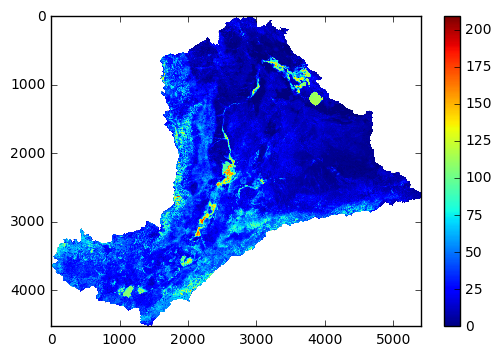

In [2]:
ET_fh=r"E:\Exercise\1.4\Monthly\L2_AETI_M\AETI_200901.tif"
ET=OpenRasterAsArray(ET_fh)
print(ET.shape)
from matplotlib import pyplot as plt
plt.imshow(ET)
plt.colorbar()
plt.show()

(90L, 107L)


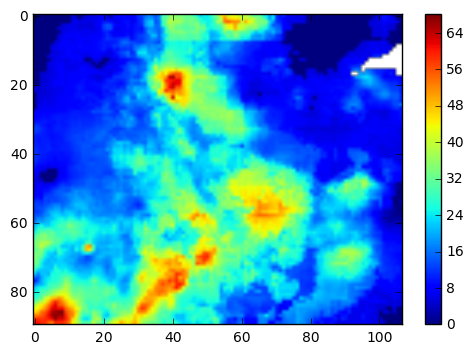

In [4]:
P_fh=r"E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200901.tif"
P=OpenRasterAsArray(P_fh)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

(5001L, 5969L)


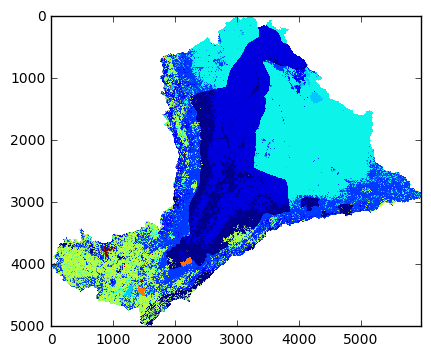

In [5]:
LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
LU=OpenRasterAsArray(LU_fh)
print(LU.shape)
plt.imshow(LU)
plt.show()

As we can see, the precipitation data has lower resolution (0.5 degree), thus, smaller array size (90x107) than the ET data (100m and 4529x5406). To these two rasters in same calculation, they must be converted to the same size, resolution and projection. This can be done using the *gdalwarp* utility, an image mosaicing, reprojection and warping utility. 
The *gdalwarp* is used to warp the given raster data to pre-defined data size and spatial extent, reproject it to pre-defined spatial reference system.To *gdalwarp* a raster file to match projection, size, extent with another raster file, the information of the target file need to be obtained first. The below function is to get nodata value, spatial reference system, data size, spatial extent of a raster file using *gdal* package. For example, here the ET raster file is the target one and we want to match projection, size, extent of the source file, which is Precipitation, with the target file.

In [6]:
def GetGdalwarpInfo(in_fh):
    SourceDs = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = SourceDs.GetDriver().ShortName
    ndv = str(SourceDs.GetRasterBand(1).GetNoDataValue()) #Target Nodata Value
    srs = SourceDs.GetProjectionRef() #Target spatial reference system 
    xsize = SourceDs.RasterXSize
    ysize = SourceDs.RasterYSize
    ts = ' '.join([str(xsize), str(ysize)]) #Target size
    GeoT = SourceDs.GetGeoTransform()
    xmin = GeoT[0]
    ymin = GeoT[3] + GeoT[5] * ysize
    xmax = GeoT[0] + GeoT[1] * xsize
    ymax = GeoT[3]
    te = ' '.join([str(xmin), str(ymin), str(xmax), str(ymax)]) #Target extent
    return ndv,srs,ts,te

s_ndv,s_srs,s_ts,s_te=GetGdalwarpInfo(P_fh)
t_ndv,t_srs,t_ts,t_te=GetGdalwarpInfo(LU_fh)

print(s_ndv,s_srs,s_ts,s_te)
print(t_ndv,t_srs,t_ts,t_te)

('-9999.0', 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]', '107 90', '37.95 7.9 43.3 12.4')
('-9999.0', 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]', '5969 5001', '37.9588320625 7.89491793773 43.3208737476 12.3873979377')


In [7]:
import subprocess
source_file=P_fh
output_folder=r'E:\Exercise\2.2\Warped\P'
output_file=os.path.join(output_folder,os.path.split(source_file)[-1])
dtype='float32'
resample='near'
string = 'gdalwarp -overwrite -s_srs {0} -t_srs {1} -te {2} -ts {3} -ot {4} -r {5} -srcnodata {6} -dstnodata {7} -of GTiff {8} {9}'.format(s_srs,t_srs,t_te,t_ts,dtype,resample,s_ndv,t_ndv,source_file,output_file)
proc = subprocess.Popen(string, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = proc.communicate()
print(out,err)

GetGdalwarpInfo(output_file)

('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')


('-9999.0',
 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]',
 '5969 5001',
 '37.9588320625 7.89491793773 43.3208737476 12.3873979377')

### Exercise (+)
Make a user-defined function to warp any raster file with a given raster.
Use this function to match projection, size, extent of all monthly precipitation and ET data with the landuse map.

In [ ]:
#%% Write your code here

In [8]:
import glob
def MatchProjResNDV(source_fh,target_fh,output_folder,dtype='float32',resample='near'):
    s_ndv,s_srs,s_ts,s_te=GetGdalwarpInfo(source_fh)
    t_ndv,t_srs,t_ts,t_te=GetGdalwarpInfo(target_fh) 
    output_file=os.path.join(output_folder,os.path.split(source_fh)[-1])
    string = 'gdalwarp -overwrite -s_srs {0} -t_srs {1} -te {2} -ts {3} -ot {4} -r {5} -srcnodata {6} -dstnodata {7} -of GTiff {8} {9}'.format(s_srs,t_srs,t_te,t_ts,dtype,resample,s_ndv,t_ndv,source_fh,output_file)
    proc = subprocess.Popen(string, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = proc.communicate()
    print(out,err)
    return output_file    

input_folder=r'E:\Exercise\1.4\Monthly\L2_AETI_M'
input_fhs=glob.glob(os.path.join(input_folder,'*.tif'))
output_folder=r'E:\Exercise\2.2\Warped\ET'
for in_fh in input_fhs:
    MatchProjResNDV(in_fh,LU_fh,output_folder)
    

('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')


In [10]:
input_folder=r'E:\Exercise\1.4\Monthly\L1_PCP_M'
input_fhs=glob.glob(os.path.join(input_folder,'*.tif'))
output_folder=r'E:\Exercise\2.2\Warped\P'
for in_fh in input_fhs:
    print(in_fh)
    MatchProjResNDV(in_fh,LU_fh,output_folder)

E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200901.tif
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200902.tif
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200903.tif
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200904.tif
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200905.tif
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200906.tif
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200907.tif
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
E:\Exercise\1.4\Monthly\L1_PCP_M\PCP_200908.tif
('0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
E:\Exercise\1.4\Monthly\L1_PCP_M

## 2. Calculate the average value of ROI
### Example
Calculate average precipitation in a ROI from a raster map (mm/month)

In [11]:
P_folder=r'E:\Exercise\2.2\Warped\P'
P_fhs=glob.glob(os.path.join(P_folder,'*.tif'))
P_fh=P_fhs[0]
P=OpenRasterAsArray(P_fh)
LU=OpenRasterAsArray(LU_fh)
print(P.shape)
print(LU.shape)

(5001L, 5969L)
(5001L, 5969L)


The Region of Interest is defined by Land-use map. A mask can be created from land-use map using *numpy.where*

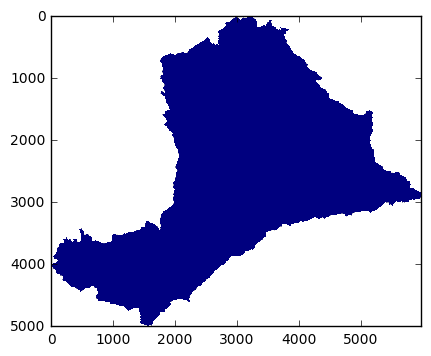

In [14]:
mask=np.where(np.isnan(LU),np.nan,1)
plt.imshow(mask)
plt.show()

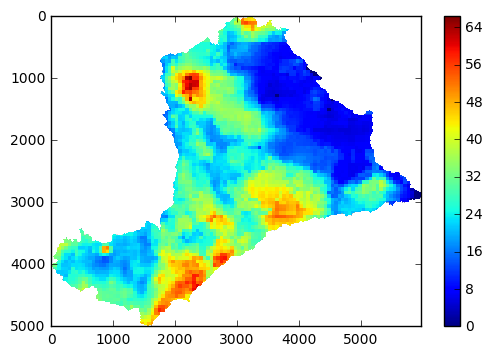

In [15]:
Basin_P=P*mask
plt.imshow(Basin_P)
plt.colorbar()
plt.show()

In [16]:
Average_P=np.nanmean(Basin_P)
print('Average Precipitation (mm/month): {0}'.format(Average_P))

Average Precipitation (mm/month): 25.6439098263


### Exercise (+)
Get values of all monthly Precipitation maps and save the value in a Python *list* and plot average precipitation against time.

**Hint**: You can make use of the file name to get *datetime* index. Look at example below.

In [17]:
import datetime

P_fh=r"E:\Exercise\2.2\Warped\P\PCP_200901.tif"
filename=os.path.split(P_fh)[-1]    
datestr=filename.split('.')[0].split('_')[-1]
print(datestr)
dyear=int(datestr[0:4])
dmonth=int(datestr[4:6])
datetime.date(dyear,dmonth,1)

200901


datetime.date(2009, 1, 1)

In [ ]:
#%% Write your code here

In [18]:
LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
LU=OpenRasterAsArray(LU_fh)
mask=np.where(np.isnan(LU),np.nan,1)

dates=[]
months=[]
years=[]
P_values=[]
for P_fh in P_fhs:
    filename=os.path.split(P_fh)[-1]    
    datestr=filename.split('.')[0].split('_')[-1]
    dyear=int(datestr[0:4]) #convert string to integer number
    dmonth=int(datestr[4:6])
    dates.append(datetime.date(dyear,dmonth,1))
    months.append(dmonth)
    years.append(dyear)
    #Calculate value
    P=OpenRasterAsArray(P_fh)    
    Basin_P=P*mask
    Average_P=np.nanmean(Basin_P)
    P_values.append(Average_P)

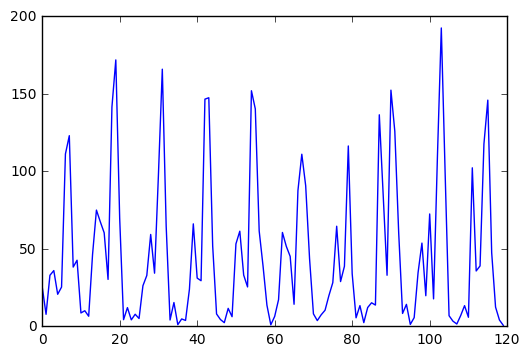

In [19]:
plt.plot(P_values)
plt.show()

We can decorate our graph with some extra code. For example

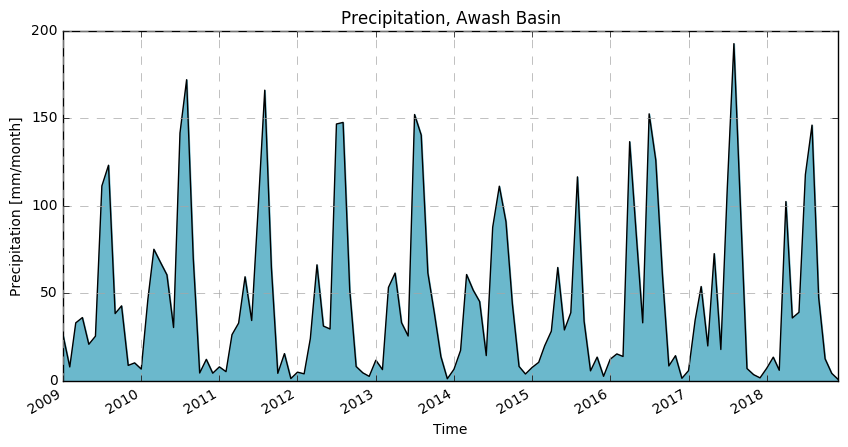

In [20]:
output_dir=r'E:\Exercise\2.2\Plots'
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
plt.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax = plt.subplot(111)
ax.plot(dates, P_values, '-k') #Plot data as line
ax.fill_between(dates, P_values, color = '#6bb8cc') #Fill line area with color
ax.set_xlabel('Time') # X axis title
ax.set_ylabel('Precipitation [mm/month]') #Y axis title
ax.set_title('Precipitation, Awash Basin') #Figure title
fig.autofmt_xdate()
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_ts.png'))
plt.show()
plt.close(fig)

## 3. Working with timeseries (pandas library)
### Example
The lists created (*dates*, *months*, *years*, *P_values*) can be combined in a DataFrame object using *pandas.DataFrame*. This structure makes cleaning, transforming, manipulating and analyzing data easier.

In [21]:
P_df=pd.DataFrame({'date':dates,'month':months,'year':years,'value': P_values})
P_df

,date,month,value,year
0,2009-01-01,1,25.643910,2009
1,2009-02-01,2,7.822536,2009
2,2009-03-01,3,33.018515,2009
3,2009-04-01,4,36.033698,2009
4,2009-05-01,5,20.751515,2009
5,2009-06-01,6,25.402913,2009
6,2009-07-01,7,111.269492,2009
7,2009-08-01,8,123.076763,2009
8,2009-09-01,9,38.306834,2009
9,2009-10-01,10,42.721977,2009


For example, we can easily sum up precipitation of the monthly values into the yearly total precipitation using *groupby* of column *year* with method *sum*.

In [22]:
Year_total=P_df.groupby(['year']).sum()
Year_total['value']

year
2009    482.887499
2010    690.525775
2011    515.055955
2012    520.744624
2013    599.004085
2014    540.812535
2015    370.520547
2016    658.558589
2017    616.277271
2018    532.151528
Name: value, dtype: float64

DataFrame columns can be converted to array and plotted easily. Below is the code to plot the total yearly precipitation. Discuss the interannual variation of precipitation in Awash.

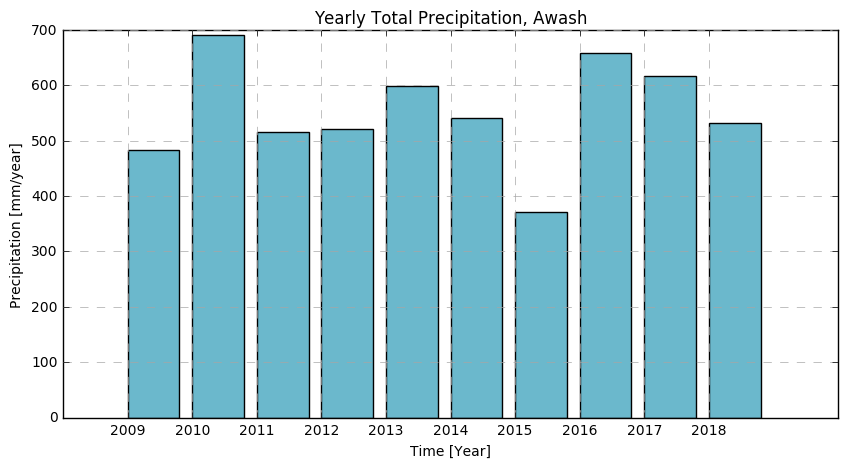

In [23]:
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
ax2 = plt.subplot(111)
ax2.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax2.bar(Year_total.index, Year_total['value'].values, 0.8, color = '#6bb8cc')
ax2.set_xlabel('Time [Year]')
ax2.set_xticks(Year_total.index)
ax2.set_ylabel('Precipitation [mm/year]')
ax2.set_title('Yearly Total Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_year.png'))
plt.show()
plt.close(fig)

### Exercise (+)
Calculate and plot the mean Precipitation of the calendar months. Discuss precipitation distribution in an average year.

**Hint**
Instead of using method *sum* in *groupby*, use *mean* 

In [ ]:
#%% Write your code here

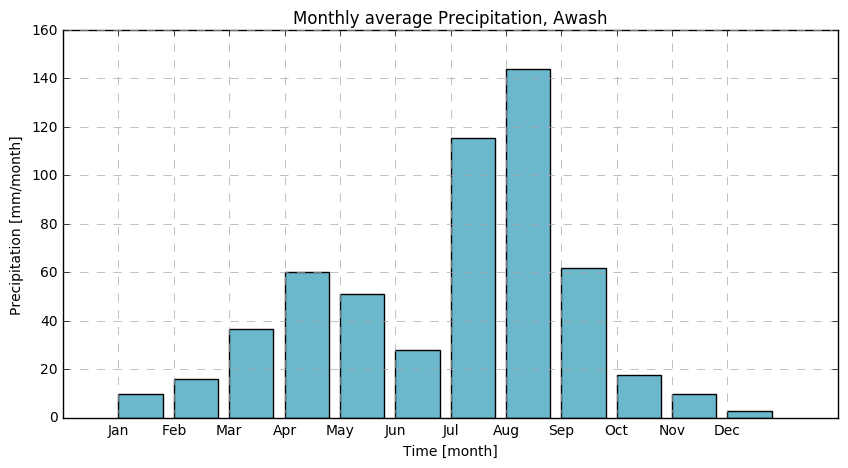

In [24]:
Month_avg=P_df.groupby(['month']).mean()
Month_avg['value']
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
#subplot 1
ax1 = plt.subplot(111)
ax1.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax1.bar(Month_avg.index, Month_avg['value'].values, 0.8, color = '#6bb8cc')
ax1.set_xlabel('Time [month]')
monthname={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
monthslabel=monthname.values()
ax1.set_xticks(Month_avg.index)
ax1.set_xticklabels(monthslabel)
ax1.set_ylabel('Precipitation [mm/month]')
ax1.set_title('Monthly average Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_month.png'))
plt.show()
plt.close(fig)

We can also save our dataframe as csv file using pandas.DataFrame method *to_csv* for later use in other analysis. 

In [26]:
Month_max=P_df.groupby(['month']).max()
Month_min=P_df.groupby(['month']).min()
Month_med=P_df.groupby(['month']).median()
Month_std=P_df.groupby(['month']).std()

Month_stat=pd.DataFrame({'month': Month_avg.index,'Mean':Month_avg['value'].values,
                        'Max':Month_max['value'].values, 'Min':Month_min['value'].values,
                        'Median':Month_med['value'].values,'Std':Month_std['value'].values})
print(Month_stat)
Month_stat.to_csv(r'E:\Exercise\2.2\P_month_stats.csv',sep=';')

           Max        Mean      Median         Min        Std  month
0    25.643910    9.551347    7.260567    4.842499   6.139329      1
1    46.453996   16.063623   11.933979    3.878622  13.908367      2
2    75.069160   36.573461   29.644979    5.911596  22.722207      3
3   136.544770   60.274347   56.563956   19.816377  36.129149      4
4    84.845797   50.788983   52.266176   20.751515  20.675400      5
5    39.045492   27.821241   29.224390   14.305187   7.460188      6
6   152.444191  115.567897  114.496883   38.825547  35.551270      7
7   192.565807  144.093199  143.174255  111.104820  26.371731      8
8    97.792709   61.705076   61.075026   33.973936  20.647026      9
9    43.789278   17.540237    8.224638    4.167911  16.955271     10
10   15.429005    9.784298   10.420884    3.422165   4.598692     11
11   10.140760    2.890132    2.010686    0.689605   2.807199     12


## 4. Raster calculation
### Example: P - ET
First, we need to get the file handler of the rasters of the same date that have been matched projection, size and resolution. We can make use of the time format in file name as below.

In [27]:
start_date='2009-01-01'
end_date='2009-12-31'
dates=pd.date_range(start_date,end_date,freq='M')
P_path=r'E:\Exercise\2.2\Warped\P\PCP_{:04d}{:02d}.tif'
ET_path=r'E:\Exercise\2.2\Warped\ET\AETI_{:04d}{:02d}.tif'

date=dates[0]
print(date)
P_fh=P_path.format(date.year,date.month)
ET_fh=ET_path.format(date.year,date.month)
print(P_fh)
print(ET_fh)

2009-01-31 00:00:00
E:\Exercise\2.2\Warped\P\PCP_200901.tif
E:\Exercise\2.2\Warped\ET\AETI_200901.tif


The difference between Precipitation and Total EvapoTranspiration (P-ET) of the pixel can indicate whether the pixel is sink or source of water. When P-ET>0, water is generated in the pixel area. When P-ET< 0, water is more depleted in the pixel area. For example, below is how we can calculate P-ET for one month (January 2009). Notice where P-ET is negative and positive.

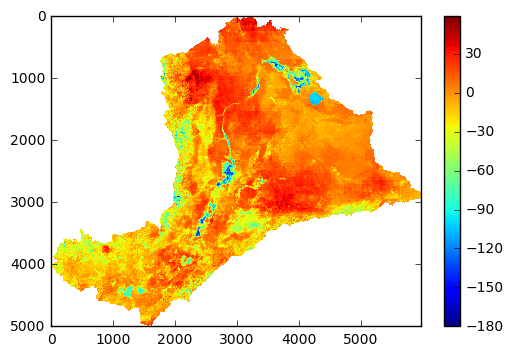

In [28]:
P=OpenRasterAsArray(P_fh)
ET=OpenRasterAsArray(ET_fh)
P_ET=P-ET
plt.imshow(P_ET)
plt.colorbar()
plt.show()

### Exercise (++) 
Calculate annual P - ET of a chosen year in Awash Basin. Discuss the source (P-ET > 0) and sink (P-ET < 0) of water and compare your year result with others.

**Hint**: You can calculate total annual map of P and ET from monthly maps then substract annual ET from annual P map or calculate difference each month then sum up. 
Questions:
- Would the two method give same results? Why?
- Which method is faster? Why?

In [ ]:
#%% Write your code here

## 5. Land-use analysis
### Example:
Get value per a land-use class (Water bodies).

In [30]:
LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
in_fh=r"E:\Exercise\2.2\Warped\ET\AETI_200901.tif"

LU=OpenRasterAsArray(LU_fh)
LU_values=np.unique(LU[~np.isnan(LU)])
LU_codes=list(LU_values)
print(LU_codes)

[1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 14.0, 16.0, 24.0, 27.0, 30.0, 35.0, 36.0, 37.0, 39.0, 40.0, 41.0, 43.0, 57.0, 72.0]


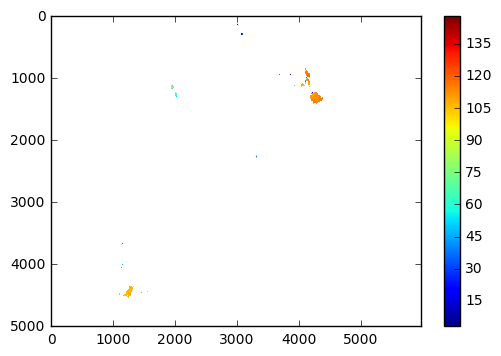

In [31]:
code=24 #Natural lake

mask=np.where(LU==code,0,1)
var=OpenRasterAsArray(in_fh)

import numpy.ma as ma
masked_map=ma.masked_array(var,mask)
plt.imshow(masked_map)
plt.colorbar()
plt.show()

In [32]:
average=np.nanmean(masked_map)
print('Landuse class {0} Average: {1}'.format(code,average))

Landuse class 24 Average: 101.971382141


### Exercise (++)
Calculate a table of annual average ET, E,T, I and P-ET of all land-use class. 
Discuss which land-use class is sink and which is source. 
Compare Evaporation in the main classes: Forest, Shrubland, Grassland, Water bodies, Bare land, Rainfed crops, Irrigated crops.

**Hints**: You can use a for-loop over all land-use classes in the land-use map.

In [ ]:
#%% Write your code here

In [33]:
averages=[]
for code in LU_codes:
    mask=np.where(LU==code,0,1)
    masked_map=ma.masked_array(var,mask)
    averages.append(np.nanmean(masked_map))
LU_avg=pd.DataFrame({'LU code':LU_codes,'Average Value': averages})
LU_avg

,Average Value,LU code
0,68.350388,1.0
1,48.799568,2.0
2,52.558819,3.0
3,94.728249,4.0
4,58.646912,5.0
5,15.842953,7.0
6,55.267586,10.0
7,36.690361,14.0
8,42.118450,16.0
9,101.971382,24.0
